# Chunking Strategy Benchmark

This notebook compares different chunking strategies for distributed video generation, specifically focusing on shared vs. independent noise initialization.

In [15]:
# !pip install scipy
# !pip install seaborn
# !pip install --upgrade ipywidgets jupyter

## 1. Setup and Imports

In [2]:
import os
import sys
import time
import logging
import numpy as np
import torch
import cv2
import torch.nn.functional as F
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from diffusers import DiffusionPipeline



logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


%matplotlib inline
plt.style.use('seaborn-v0_8')

## 2. Load VAE

In [3]:
# Load the VAE from Zeroscope
model_id = "cerspense/zeroscope_v2_576w"
device = "cuda" if torch.cuda.is_available() else "cpu"

logger.info(f"Loading VAE from {model_id}")
pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    use_safetensors=False
).to(device)

# Extract VAE
vae = pipe.vae
vae.eval()
logger.info("VAE loaded successfully")

2025-04-20 14:17:22,127 - __main__ - INFO - Loading VAE from cerspense/zeroscope_v2_576w


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-20 14:17:26,081 - __main__ - INFO - VAE loaded successfully


## 3. Benchmark Class

In [4]:
class ChunkingBenchmark:
    def __init__(self, 
                 num_frames: int = 16,
                 chunk_size: int = 8,
                 overlap: int = 2,
                 device: str = "cuda"):
        self.num_frames = num_frames
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.device = device
        
    def generate_noise(self, shared: bool = False) -> List[Dict]:
        """Generate noise for chunks with or without shared initialisation."""
        if shared:
            base_noise = torch.randn((1, 4, self.num_frames, 64, 64), device=self.device)
            
            chunks = []
            for i in range(0, self.num_frames, self.chunk_size - self.overlap):
                start = i
                end = min(i + self.chunk_size, self.num_frames)
                
                # For overlapping regions, use the same noise
                if i > 0:
                    chunk_noise = base_noise[:, :, start:end].clone()
                    chunk_noise[:, :, :self.overlap] = base_noise[:, :, start:start+self.overlap]
                else:
                    chunk_noise = base_noise[:, :, start:end]
                    
                chunks.append({
                    'chunk': chunk_noise,
                    'start_idx': start,
                    'end_idx': end
                })
        else:
            # Generate independent noise for each chunk
            chunks = []
            for i in range(0, self.num_frames, self.chunk_size - self.overlap):
                start = i
                end = min(i + self.chunk_size, self.num_frames)
                chunk_noise = torch.randn((1, 4, end-start, 64, 64), device=self.device)
                
                chunks.append({
                    'chunk': chunk_noise,
                    'start_idx': start,
                    'end_idx': end
                })
        
        return chunks
    
    def decode_latents(self, latents: torch.Tensor) -> torch.Tensor:
        """Decode latents to pixel space using the VAE."""
        with torch.no_grad():
            # Reshape latents for VAE decoding
            batch_size, channels, num_frames, height, width = latents.shape
            latents_reshaped = latents.permute(0, 2, 1, 3, 4).reshape(-1, channels, height, width)
            
            # Match datatype precision to model
            latents_reshaped = latents_reshaped.to(vae.dtype)

            # Decode all frames at once
            video_frames = vae.decode(latents_reshaped / 0.18215).sample
            
            # Reshape back to (batch, frames, channels, height, width)
            video_frames = video_frames.reshape(batch_size, num_frames, -1, height * 8, width * 8)
            
            # Permute to (batch, channels, frames, height, width)
            video_frames = video_frames.permute(0, 2, 1, 3, 4)
            
            # Post-process the frames
            video_frames = (video_frames / 2 + 0.5).clamp(0, 1)
            
            return video_frames
    
    def compute_optical_flow(self, frames: torch.Tensor) -> torch.Tensor:
        """
        Compute optical flow between consecutive frames.
        
        """
        # Move to CPU numpy for OpenCV
        frames_np = (frames.permute(1, 2, 3, 0)
                        .cpu()
                        .numpy() * 255).astype(np.uint8)

        flows = []
        for i in range(len(frames_np) - 1):
            prev_rgb = frames_np[i]     # shape (H, W, 3)
            curr_rgb = frames_np[i+1]   # shape (H, W, 3)

            # Convert to gray
            prev_gray = cv2.cvtColor(prev_rgb, cv2.COLOR_RGB2GRAY)
            curr_gray = cv2.cvtColor(curr_rgb, cv2.COLOR_RGB2GRAY)

            # Compute optical flow
            flow = cv2.calcOpticalFlowFarneback(
                prev_gray, curr_gray,
                None,
                pyr_scale=0.5, levels=3, winsize=15,
                iterations=3, poly_n=5, poly_sigma=1.2, flags=0
            )
            flows.append(flow)

        # Return tensor of shape (F-1, H, W, 2)
        return torch.from_numpy(np.stack(flows)).to(self.device)
            

    
    def compute_flow_consistency(self, flows: torch.Tensor) -> float:
        """Compute consistency of optical flow between frames."""

        flow_diffs = torch.diff(flows, dim=0)
        flow_magnitudes = torch.norm(flow_diffs, dim=-1)
        
        # Lower magnitude differences indicate more consistent flow
        return float(1.0 / (1.0 + flow_magnitudes.mean()))
    
    def compute_overlap_similarity(self, chunks: List[Dict]) -> float:
        """Compute similarity between overlapping regions of chunks."""
        similarities = []
        for i in range(len(chunks) - 1):
            current_chunk = chunks[i]['chunk']
            next_chunk = chunks[i+1]['chunk']
            
            # Get overlapping regions
            overlap_current = current_chunk[:, :, -self.overlap:]
            overlap_next = next_chunk[:, :, :self.overlap]
            
            # Compute similarity (MSE)
            similarity = F.mse_loss(overlap_current, overlap_next)
            similarities.append(float(similarity))
        
        return float(np.mean(similarities))
    
    def run_benchmark(self, num_runs: int = 5) -> Dict:
        """Run benchmark comparing shared and independent noise initialization."""
        results = {
            'shared_noise': {
                'flow_consistency': [],
                'overlap_similarity': [],
                'generation_time': []
            },
            'independent_noise': {
                'flow_consistency': [],
                'overlap_similarity': [],
                'generation_time': []
            }
        }
        
        for method in ['shared_noise', 'independent_noise']:
            logger.info(f"Running benchmark for {method}")
            
            for run in tqdm(range(num_runs), desc=method):
                # Generate noise
                start_time = time.time()
                chunks = self.generate_noise(shared=(method == 'shared_noise'))
                generation_time = time.time() - start_time
                
                # Compute metrics
                overlap_similarity = self.compute_overlap_similarity(chunks)
                
                # Decode latents and compute flow consistency
                decoded_frames = self.decode_latents(chunks[0]['chunk'])
                flows = self.compute_optical_flow(decoded_frames[0])
                flow_consistency = self.compute_flow_consistency(flows)
                
                # Store results
                results[method]['flow_consistency'].append(flow_consistency)
                results[method]['overlap_similarity'].append(overlap_similarity)
                results[method]['generation_time'].append(generation_time)
        
        return results

## 4. Run Benchmark

In [5]:
# Initialise benchmark
benchmark = ChunkingBenchmark(
    num_frames=16,
    chunk_size=8,
    overlap=2
)

# Run benchmark
results = benchmark.run_benchmark(num_runs=1000)

2025-04-20 14:17:32,911 - __main__ - INFO - Running benchmark for shared_noise


shared_noise:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 14:31:17,585 - __main__ - INFO - Running benchmark for independent_noise


independent_noise:   0%|          | 0/1000 [00:00<?, ?it/s]

## 5. Visualise Results

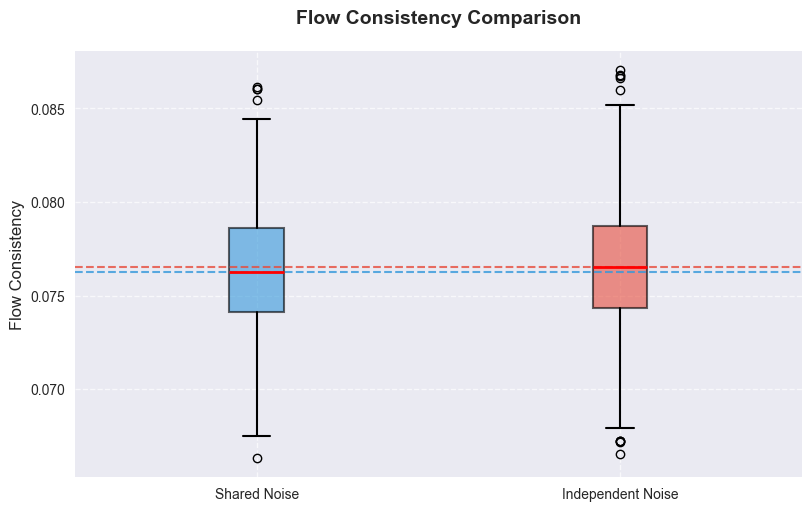

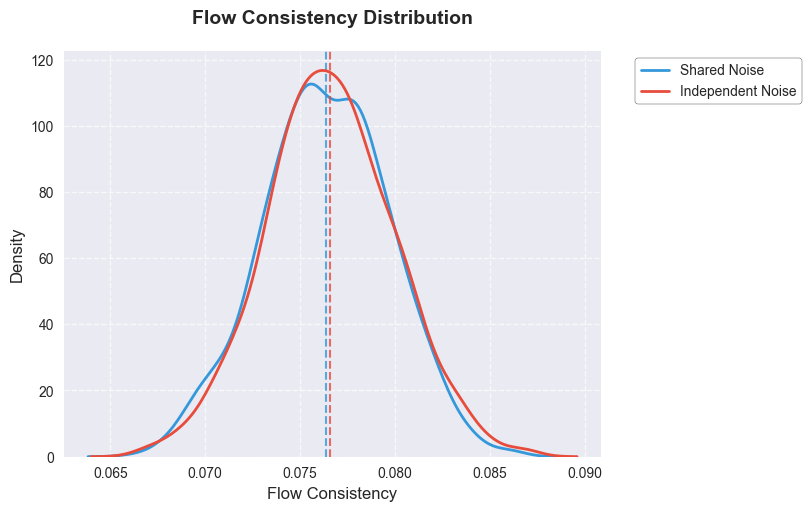

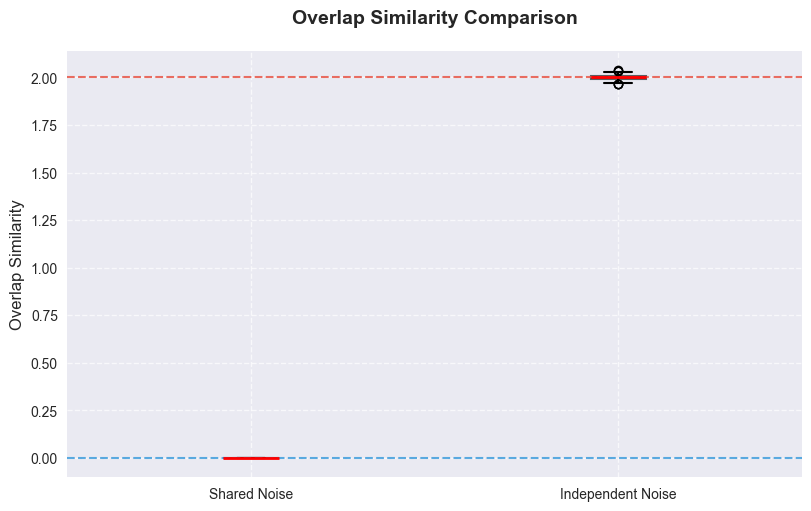

/tmp/ipykernel_4076346/3905488660.py:72: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data,


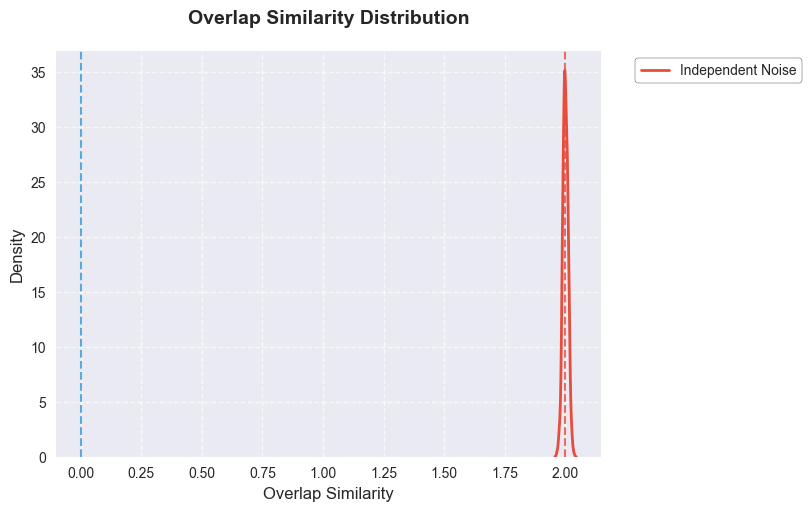

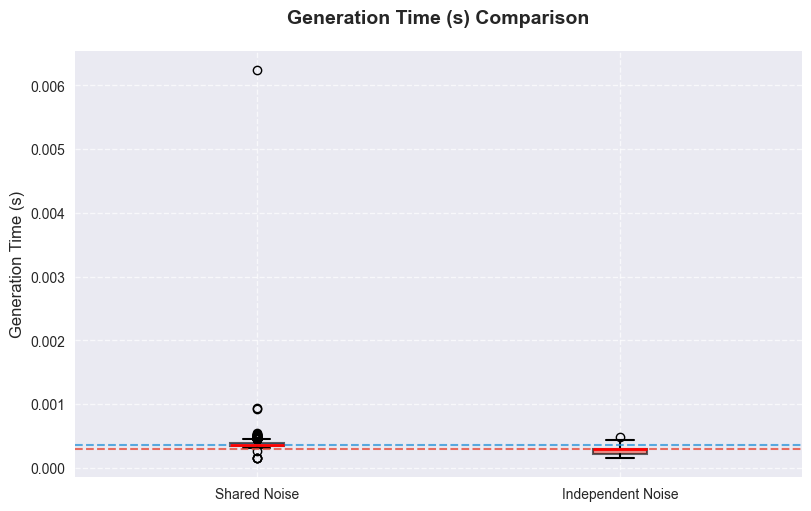

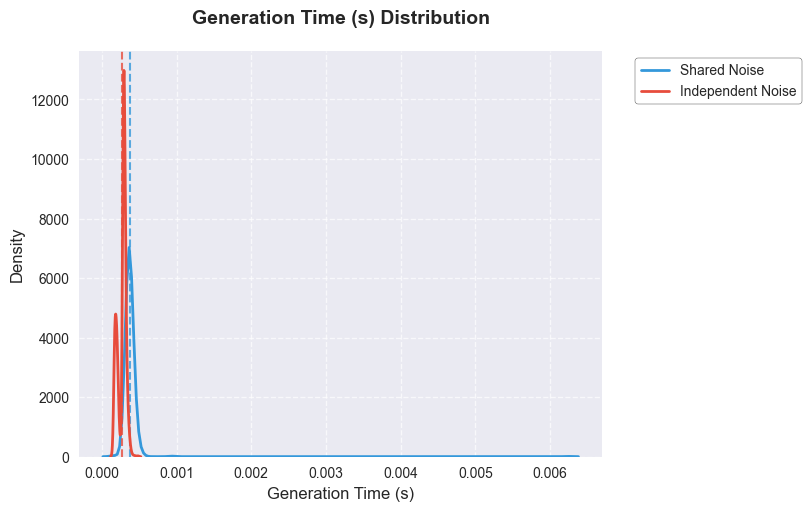

In [6]:
def plot_metric_comparison(results: dict, metric: str):
    """Plot comparison of a specific metric between methods."""
    
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    

    methods = ['Shared Noise', 'Independent Noise']
    data = [results[method.lower().replace(' ', '_')][metric] for method in methods]
    
    
    boxprops = dict(linestyle='-', linewidth=1.5, color='black')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
    capprops = dict(linestyle='-', linewidth=1.5, color='black')
    medianprops = dict(linestyle='-', linewidth=2, color='red')
    
    bp = ax.boxplot(data, 
                    tick_labels=methods,
                    patch_artist=True,
                    boxprops=boxprops,
                    whiskerprops=whiskerprops,
                    capprops=capprops,
                    medianprops=medianprops)
    
    
    colors = ['#3498db', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
 
    for i, method_data in enumerate(data, 1):
        median_val = np.median(method_data)
        ax.axhline(y=median_val, xmin=0, xmax=1, 
                  color=colors[i-1], 
                  linestyle='--', 
                  linewidth=1.5,
                  alpha=0.8)
    
 
    metric_names = {
        'flow_consistency': 'Flow Consistency',
        'overlap_similarity': 'Overlap Similarity',
        'generation_time': 'Generation Time (s)'
    }
    
    ax.set_title(f'{metric_names[metric]} Comparison', 
                fontsize=14, pad=20, fontweight='bold')
    ax.set_ylabel(metric_names[metric], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

def plot_metric_distribution(results: dict, metric: str):
    """Plot distribution of a specific metric."""
    
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    
 
    methods = ['Shared Noise', 'Independent Noise']
    colors = ['#3498db', '#e74c3c']
    
    for method, color in zip(methods, colors):
        data = results[method.lower().replace(' ', '_')][metric]
        sns.kdeplot(data=data, 
                   label=method,
                   color=color,
                   linewidth=2,
                   ax=ax)
        

        mean_val = np.mean(data)
        ax.axvline(x=mean_val, 
                  color=color, 
                  linestyle='--', 
                  linewidth=1.5,
                  alpha=0.8)
    
 
    metric_names = {
        'flow_consistency': 'Flow Consistency',
        'overlap_similarity': 'Overlap Similarity',
        'generation_time': 'Generation Time (s)'
    }
    
    ax.set_title(f'{metric_names[metric]} Distribution', 
                fontsize=14, pad=20, fontweight='bold')
    ax.set_xlabel(metric_names[metric], fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    
    ax.legend(fontsize=10, frameon=True, 
             facecolor='white', edgecolor='black',
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
  
    ax.grid(True, linestyle='--', alpha=0.7)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()


for metric in ['flow_consistency', 'overlap_similarity', 'generation_time']:
    plot_metric_comparison(results, metric)
    plot_metric_distribution(results, metric)

## 6. Statistical Analysis

In [22]:
def print_statistical_analysis(results: dict):
    """Print statistical analysis of the results."""
    print("Statistical Analysis")
    print("==================")
    
    for metric in ['flow_consistency', 'overlap_similarity', 'generation_time']:
        print(f"\n{metric.replace('_', ' ').title()}:")
        
        shared = results['shared_noise'][metric]
        independent = results['independent_noise'][metric]
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(shared, independent)
        
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        
        # Print means and standard deviations
        print(f"  Shared noise:")
        print(f"    Mean: {np.mean(shared):.4f}")
        print(f"    Std: {np.std(shared):.4f}")
        print(f"  Independent noise:")
        print(f"    Mean: {np.mean(independent):.4f}")
        print(f"    Std: {np.std(independent):.4f}")

print_statistical_analysis(results)

Statistical Analysis

Flow Consistency:
  t-statistic: 1.1289
  p-value: 0.2603
  Significant difference: No
  Shared noise:
    Mean: 0.0768
    Std: 0.0032
  Independent noise:
    Mean: 0.0763
    Std: 0.0030

Overlap Similarity:
  t-statistic: -1872.9606
  p-value: 0.0000
  Significant difference: Yes
  Shared noise:
    Mean: 0.0000
    Std: 0.0000
  Independent noise:
    Mean: 1.9990
    Std: 0.0106

Generation Time:
  t-statistic: 3.1025
  p-value: 0.0022
  Significant difference: Yes
  Shared noise:
    Mean: 0.0005
    Std: 0.0007
  Independent noise:
    Mean: 0.0003
    Std: 0.0001


## 7. Save Results

In [9]:
# Save results to file
output_file = "benchmark_results.npz"
np.savez(output_file, **results)
print(f"Results saved to {output_file}")

Results saved to benchmark_results.npz
